# Retraining Model using Model Recombination (r2)

In [1]:
!pip install tensorflow[and-cuda] matplotlib numpy seaborn scikit-learn pillow

In [29]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16  # Example of a pre-trained model
# from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

## Load Your Existing Model

In [30]:
# Load your existing .keras model
your_model = load_model('./models/r1_expression_classification_model.keras')

## Load a Public Model (e.g., MobileNetV2)

In [31]:
# Load a public model
public_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# public_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers of the public model
for layer in public_model.layers:
    layer.trainable = False

## Prepare Data for Training and Validation

In [41]:
# Prepare data
train_dir = './face-expression-recognition-dataset/images/train'
validation_dir = './face-expression-recognition-dataset/images/validation'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=50,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=50,
    class_mode='categorical'
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


## Combine Your Model with the Public Model

In [42]:
# Combine models
x = public_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  # Add a dense layer if needed

# Add final output layer based on the number of classes in your dataset
num_classes = train_generator.num_classes
output_layer = Dense(num_classes, activation='softmax')(x)

# Define the final combined model
final_model = Model(inputs=public_model.input, outputs=output_layer)


## Compile and Train the Combined Model

### compile and get the model info

In [43]:
# Define the callbacks
checkpoint = ModelCheckpoint('./models/r2_best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=4, min_lr=0.0001, mode='min')

# Combine all callbacks into a list
callbacks = [checkpoint, early_stopping, reduce_lr]

# Compile the model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
final_model.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,576,903 (13.64 MB)

 Trainable params: 1,318,919 (5.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### model training

In [45]:
# Train the model with callbacks
history = final_model.fit(
    train_generator,
    epochs=150,
    validation_data=validation_generator,
    callbacks=callbacks,
    # shuffle=True
)

Epoch 1/150
575/577 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step - accuracy: 0.3816 - loss: 1.5743

2024-09-07 23:39:36.839943: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1191', 16 bytes spill stores, 16 bytes spill loads



577/577 ━━━━━━━━━━━━━━━━━━━━ 403s 692ms/step - accuracy: 0.3816 - loss: 1.5743 - val_accuracy: 0.4240 - val_loss: 1.4835 - learning_rate: 0.0010
Epoch 2/150
577/577 ━━━━━━━━━━━━━━━━━━━━ 368s 631ms/step - accuracy: 0.4075 - loss: 1.5322 - val_accuracy: 0.4144 - val_loss: 1.4947 - learning_rate: 0.0010
Epoch 3/150
577/577 ━━━━━━━━━━━━━━━━━━━━ 368s 631ms/step - accuracy: 0.4073 - loss: 1.5102 - val_accuracy: 0.4280 - val_loss: 1.4729 - learning_rate: 0.0010
Epoch 4/150
577/577 ━━━━━━━━━━━━━━━━━━━━ 367s 629ms/step - accuracy: 0.4248 - loss: 1.4821 - val_accuracy: 0.4374 - val_loss: 1.4468 - learning_rate: 0.0010
Epoch 5/150
577/577 ━━━━━━━━━━━━━━━━━━━━ 361s 619ms/step - accuracy: 0.4300 - loss: 1.4771 - val_accuracy: 0.4377 - val_loss: 1.4430 - learning_rate: 0.0010
Epoch 6/150
577/577 ━━━━━━━━━━━━━━━━━━━━ 369s 633ms/step - accuracy: 0.4298 - loss: 1.4618 - val_accuracy: 0.4481 - val_loss: 1.4228 - learning_rate: 0.0010
Epoch 7/150
577/577 ━━━━━━━━━━━━━━━━━━━━ 365s 624ms/step - accuracy: 0

## Plot Training History

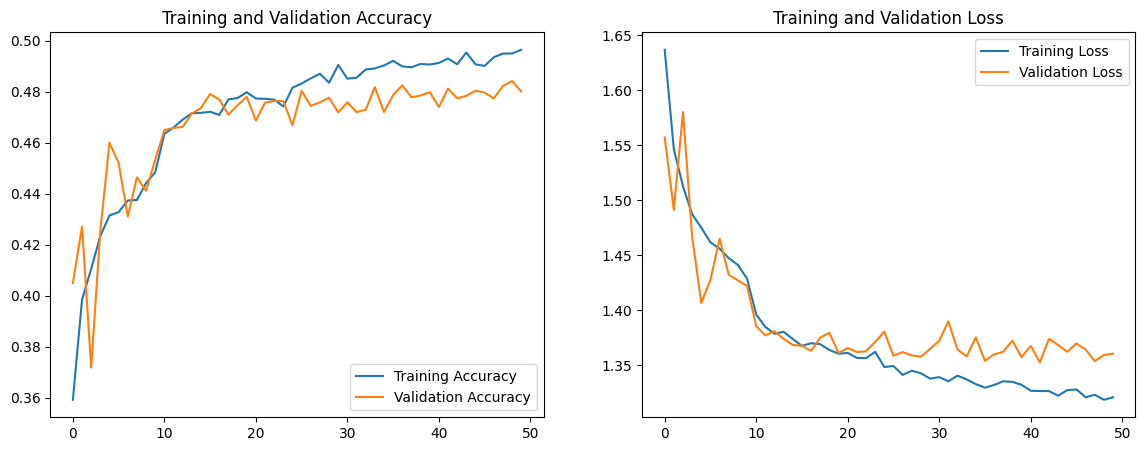

In [36]:
# Plot training & validation accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)

## Evaluate the Model - Confusion Matrix and Classification Report

221/221 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step


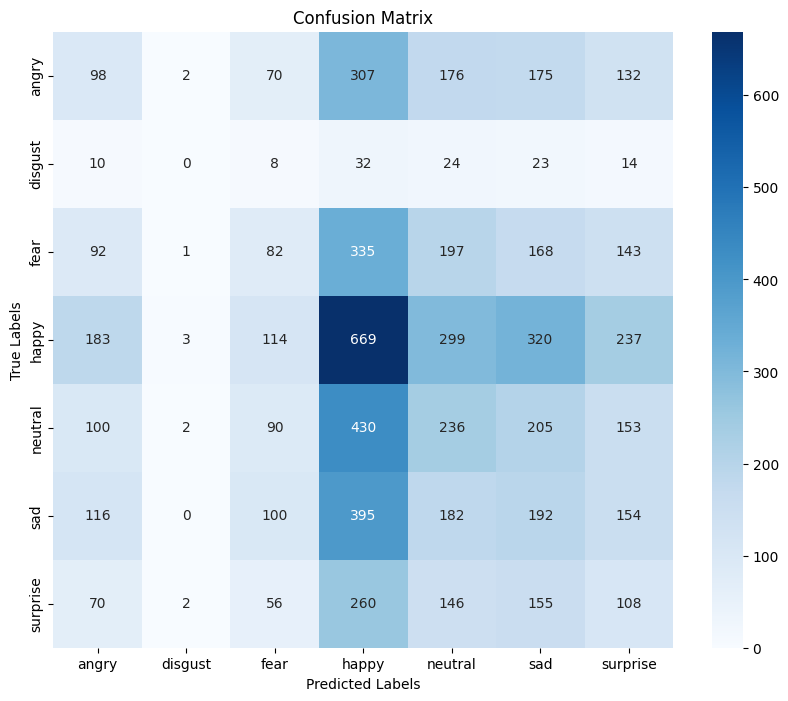

              precision    recall  f1-score   support

       angry       0.15      0.10      0.12       960
     disgust       0.00      0.00      0.00       111
        fear       0.16      0.08      0.11      1018
       happy       0.28      0.37      0.31      1825
     neutral       0.19      0.19      0.19      1216
         sad       0.16      0.17      0.16      1139
    surprise       0.11      0.14      0.12       797

    accuracy                           0.20      7066
   macro avg       0.15      0.15      0.15      7066
weighted avg       0.18      0.20      0.19      7066



In [37]:
# Confusion matrix and classification report
def plot_confusion_matrix_and_report(model, validation_generator):
    Y_pred = model.predict(validation_generator)
    y_pred = np.argmax(Y_pred, axis=1)

    true_classes = validation_generator.classes
    class_labels = list(validation_generator.class_indices.keys())

    # Create confusion matrix
    cm = confusion_matrix(true_classes, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print(classification_report(true_classes, y_pred, target_names=class_labels))

plot_confusion_matrix_and_report(final_model, validation_generator)

## Visualize Model Performance on Random Validation Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


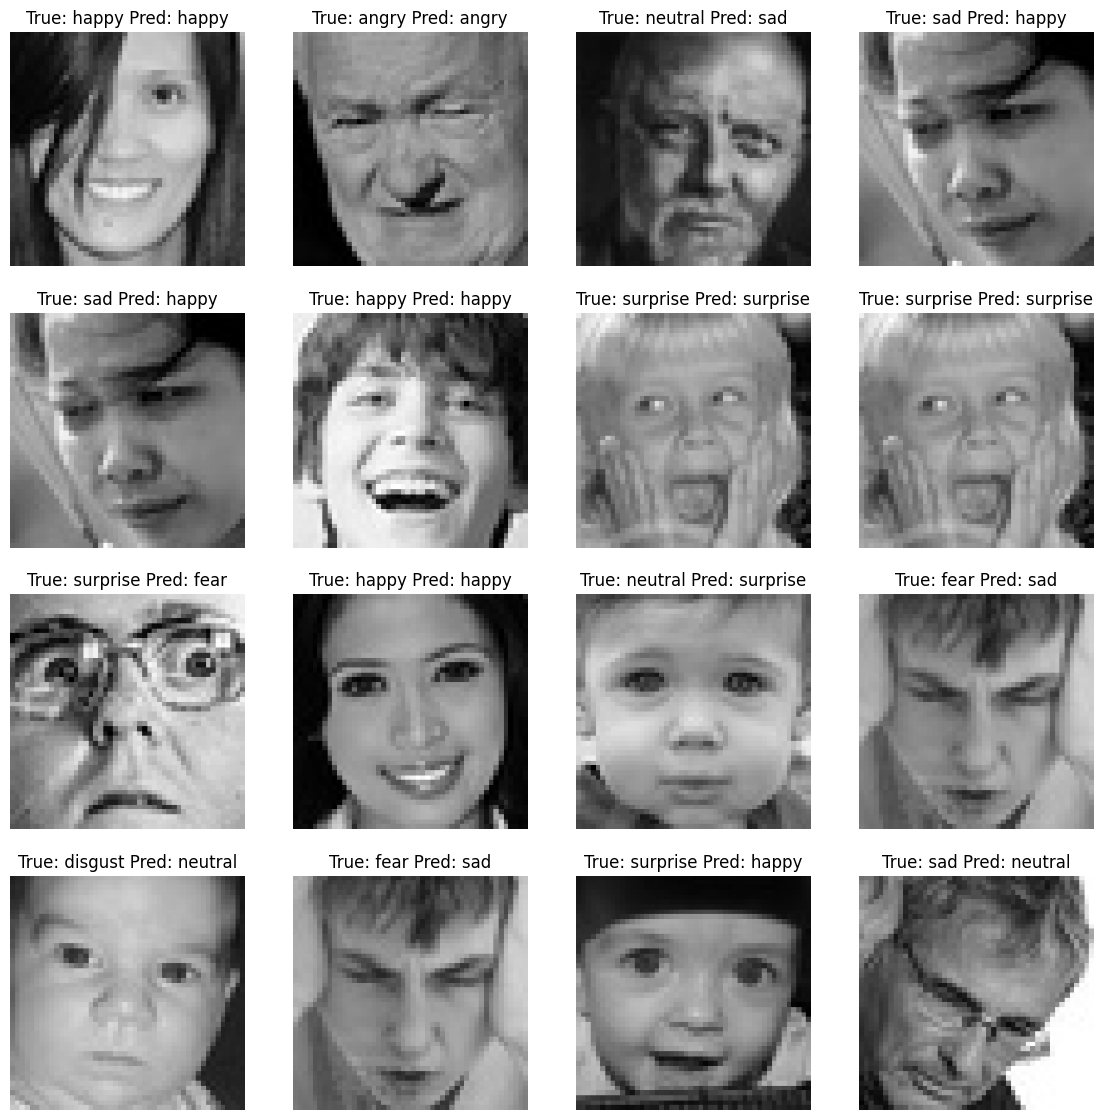

In [38]:
# Randomly select and display 16 validation images with predictions
def show_random_predictions(model, validation_generator):
    # Get a batch of validation images and their corresponding labels
    validation_images, validation_labels = next(validation_generator)
    predictions = model.predict(validation_images)
    predicted_labels = np.argmax(predictions, axis=1)

    class_labels = list(validation_generator.class_indices.keys())

    plt.figure(figsize=(14, 14))
    for i in range(16):
        idx = random.randint(0, validation_images.shape[0] - 1)
        img = validation_images[idx]
        true_label = np.argmax(validation_labels[idx])
        predicted_label = predicted_labels[idx]

        plt.subplot(4, 4, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_labels[true_label]} Pred: {class_labels[predicted_label]}")
        plt.axis('off')

    plt.show()

# Example call (ensure `final_model` and `validation_generator` are defined)
show_random_predictions(final_model, validation_generator)

## Evaluate the Model on Validation Data

In [39]:
# After training, evaluate, plot, and show example predictions
evaluation = final_model.evaluate(validation_generator)
print(f"Validation Loss: {evaluation[0]}")
print(f"Validation Accuracy: {evaluation[1]}")

221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.4856 - loss: 1.3540
Validation Loss: 1.352636694908142
Validation Accuracy: 0.4811774790287018


## Save the Retrained Model

In [40]:
# Save the retrained model
final_model.save('./models/r2_expression_classification_model.keras')
print("Model saved as 'r2_expression_classification_model.keras'")

Model saved as 'r2_expression_classification_model.keras'
